# Twitter Climate Change Sentiment Analysis

* Author: Roelle Kim
* Date: 2022-04-05


# Used Dataset
"Twitter Climate Change Sentiment" at https://www.kaggle.com/datasets/edqian/twitter-climate-change-sentiment-dataset.

# Objective
The goal for the model is to distinguish tweets about climate change into one of the three labels:
* 2: news - factual news about the climate change
* 1: pro - support the belief that climate change is caused by the man-kinds.
* 0: neutral
* -1: anti - refuse the belief that climate change is caused by the man-kinds

# EDA


## Load Packages and Data
Before analyzing data, we need to import required packages and the dataset.

In [3]:
# pip install pydataset

In [4]:
# import packages
import pandas as pd
import numpy as np
from os import makedirs
from os import path
import math
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import nltk.downloader
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.util import ngrams

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from pydataset import data
from sklearn.ensemble        import BaggingClassifier, \
         ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import RidgeClassifier
from sklearn.svm             import SVC
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

import pickle
import json

import kagglehub
from kagglehub import KaggleDatasetAdapter

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
file_path = "twitter_sentiment_data.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "edqian/twitter-climate-change-sentiment-dataset",
  file_path,)

/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_29341/399500820.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


In [7]:
df.groupby('sentiment').size()

sentiment
-1     3990
 0     7715
 1    22962
 2     9276
dtype: int64

In [119]:
# set up label dataframe for future refrences

label = [
    -1,
    0,
    1,
     2
]
labelN = [
    "Anti",
    "Neutral",
    "Pro",
      "News"
]
labelDesc = [
    "the tweet does not believe in man-made climate change",
    "the tweet neither supports nor refutes the belief of man-made climate change",
    "the tweet supports the belief of man-made climate change",
    "the tweet links to factual news about climate change"
]

labelDf = pd.DataFrame(
    list(zip(label, labelN, labelDesc)), columns=["label", "name", "description"]
)

## Data Dictionary

In [120]:
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting hustle as it was global warming but the p...,792927353886371840
1,1,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world...",793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of cl...",793125156185137153


The data has a very simple structure with only 2 features. Each row is associated with a unique tweetid, and it shows a tweet pertaining to man-made climate change. The message column shows the content of the tweet and the sentiment column shows the sentiment label that was determined by 3 reviewers.

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  43943 non-null  int64 
 1   message    43943 non-null  object
 2   tweetid    43943 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


There are total of 43949 entries with no null counts.

## Distribution of Sentiments

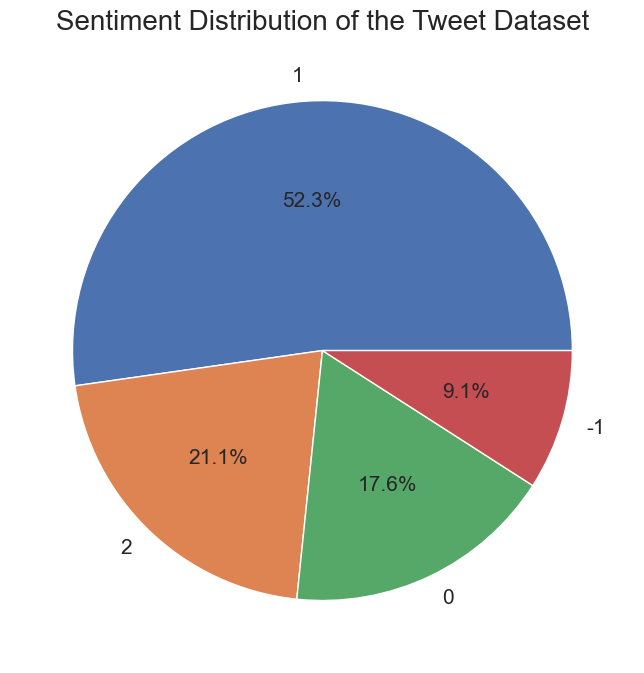

In [122]:
plt.figure(figsize = (7, 7))
plt.pie(df.sentiment.value_counts().values, labels = df.sentiment.value_counts().index, autopct = '%2.1f%%', textprops={'fontsize': 15})
plt.title('Sentiment Distribution of the Tweet Dataset', fontsize=20)
plt.tight_layout()
plt.show()

The pie chart shows the distribution of the data. Majority of tweets are labelled as "1" meaning the positive attitude toward the belief that the climate change is caused by the man-kinds, followed by "2"(news), "0"(neutral), and "-1"(anti).

In [123]:
df.sentiment.value_counts()

sentiment
 1    22962
 2     9276
 0     7715
-1     3990
Name: count, dtype: int64

These are the exact numbers of each sentiment label.

# Data Preparation for Sentiment Analysis
Tweet texts will be transformed and vectorized to be fed into models.

In [124]:
# separate the messages column for transformation.
dfTweets = df["message"]

In [125]:
dfTweets

0        @tiniebeany climate change is an interesting hustle as it was global warming but the p...
1        RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world...
2        Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https...
3        RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate...
4        RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of cl...
                                                   ...                                            
43938    Dear @realDonaldTrump,\nYeah right. Human Mediated Climate Change is a Chinese urban l...
43939          What will your respective parties do to prevent climate change globally? #ZPNDebate
43940    RT @MikkiL: UN Poll Shows Climate Change Is the Lowest of All Global Concerns https://...
43941    RT @taehbeingextra: i still can$q$t believe this gif of taehyung saved the human race,...
43942    @

## Tokenization
All the tweets are first split into arrays of words.

In [126]:
def createTokenizedArray(sentences):
    '''
    Create lower case array of words with no punctuation.
    :param sentences: array or series of texts
    :return: lower case array of words with no punctuation.
    '''
    # Initialize tokenizer and empty array to store modified sentences.
    tokenizer = RegexpTokenizer(r'\w+')
    tokenizedArray = []
    for i in range(0, len(sentences)):
        # Convert sentence to lower case.
        sentence = sentences[i].lower()

        # Split sentence into array of words with no punctuation.
        words = tokenizer.tokenize(sentence)

        # Append word array to list.
        tokenizedArray.append(words)

    # print(tokenizedArray)
    return tokenizedArray  # send modified contents back to calling function.

In [127]:
tokenizedLi = createTokenizedArray(dfTweets)

pd.Series(tokenizedLi[:5])

0    [tiniebeany, climate, change, is, an, interesting, hustle, as, it, was, global, warmin...
1    [rt, natgeochannel, watch, beforetheflood, right, here, as, leodicaprio, travels, the,...
2    [fabulous, leonardo, dicaprio, s, film, on, climate, change, is, brilliant, do, watch,...
3    [rt, mick_fanning, just, watched, this, amazing, documentary, by, leonardodicaprio, on...
4    [rt, cnalive, pranita, biswasi, a, lutheran, from, odisha, gives, testimony, on, effec...
dtype: object

Each array contains words of individual tweet.

## Stop Word Removal
Stop words are the words that do not add any significant values to the query search, such as "the", "a", and "an". They are safe to be removed from the tokenized list.

In [128]:
# To get stop words.
nltk.download('stopwords')

def removeStopWords(tokenList):
    '''
    Create array of words with no punctuation or stop words.
    :param tokenList: tokenized list
    :return: array of words with no punctuation or stop words.
    '''
    stopWords = set(stopwords.words('english'))
    shorterSentences = []  # Declare empty array of sentences.

    for sentence in tokenList:
        shorterSentence = []  # Declare empty array of words in single sentence.
        for word in sentence:
            if word not in stopWords:

                # Remove leading and trailing spaces.
                word = word.strip()

                # Ignore single character words and digits.
                if (len(word) > 1 and word.isdigit() == False):
                    # Add remaining words to list.
                    shorterSentence.append(word)
        shorterSentences.append(shorterSentence)
    return shorterSentences

[nltk_data] Downloading package stopwords to /Users/nafis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [129]:
tokenizedNoStopLi = removeStopWords(tokenizedLi)

print(f"Sample sentence BEFORE removing stop words:\n{tokenizedLi[0]}")
print(f"\n\nSample sentence AFTER removing stop words:\n{tokenizedNoStopLi[0]}")

Sample sentence BEFORE removing stop words:
['tiniebeany', 'climate', 'change', 'is', 'an', 'interesting', 'hustle', 'as', 'it', 'was', 'global', 'warming', 'but', 'the', 'planet', 'stopped', 'warming', 'for', '15', 'yes', 'while', 'the', 'suv', 'boom']


Sample sentence AFTER removing stop words:
['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']


You can see the second set of the array now no longer contains some insignificant words such as "is", "an", "as" and "it".

## Stemming
English words are often time variations of a root word. Stemming rebuilds sentences by removing suffixes from words. It potentially improves the sentiment algorithm by accepting different words as one word as long as they were originated from the same stem.

In [130]:
def stemWords(sentenceArrays):
    '''
    Removes suffixes and rebuilds the sentences.
    :param sentenceArrays: stentences list
    :return: array of sentences without suffixes
    '''
    ps = PorterStemmer()
    stemmedSentences = []
    for sentenceArray in sentenceArrays:
        stemmedArray = []  # Declare empty array of words.
        for word in sentenceArray:
            stemmedArray.append(ps.stem(word))  # Add stemmed word.

        # Convert array back to sentence of stemmed words.
        delimeter = ' '
        sentence = delimeter.join(stemmedArray)

        # Append stemmed sentence to list of sentences.
        stemmedSentences.append(sentence)
    return stemmedSentences

In [131]:
stemmedLi = stemWords(tokenizedNoStopLi)

print(f"Sample sentence BEFORE stemming:\n{tokenizedNoStopLi[0]}")
print(f"\nSample sentence AFTER stemming:\n{stemmedLi[0]}")

Sample sentence BEFORE stemming:
['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']

Sample sentence AFTER stemming:
tiniebeani climat chang interest hustl global warm planet stop warm ye suv boom


You can see the sentence after stemming has lost some suffixes. "Change" became "chang", "interesting" became "interest" and "warming" became "warm". The array of words has also been converted back to one full sentence.

## Vectorization
Now the stemmed sentences will be vectorized. It essentially transforms all the existing words into numbers so they can be fed to various big data algorithms.

In [132]:
def vectorizeList(stemmedList, ngramRangeStart, ngramRangeEnd):
    '''
    Creates a matrix of word vectors.
    :param stemmedList: stemmed sentence list
    :return: matrix of word vectors and vocabulary dictionary
    '''
    cv = CountVectorizer(binary=True, ngram_range=(ngramRangeStart, ngramRangeEnd))
    cv.fit(stemmedList)
    X = cv.transform(stemmedList)

    return X, cv.vocabulary_

In [133]:
vectorizedTweets, vectorDictionary = vectorizeList(stemmedLi, 1, 1)

Let's look into 2 different sample sentences to understand better what vectorization does

In [134]:
print(f"Sample sentence #1:\n{stemmedLi[0]}")
print(f"Sample sentence #2:\n{stemmedLi[1]}")

Sample sentence #1:
tiniebeani climat chang interest hustl global warm planet stop warm ye suv boom
Sample sentence #2:
rt natgeochannel watch beforetheflood right leodicaprio travel world tackl climat chang http co lkdehj3tnn httã


Notice these 2 sentences have a couple of words in common - "climat", "chang"

In [135]:
print(f"\n#1 after vectorization:\n{vectorizedTweets[0]}")
print(f"#2 after vectorization:\n{vectorizedTweets[1]}")


#1 after vectorization:
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 12 stored elements and shape (1, 67195)>
  Coords	Values
  (0, 10652)	1
  (0, 12943)	1
  (0, 13774)	1
  (0, 24524)	1
  (0, 27759)	1
  (0, 29419)	1
  (0, 45475)	1
  (0, 54598)	1
  (0, 55193)	1
  (0, 57219)	1
  (0, 61855)	1
  (0, 64839)	1
#2 after vectorization:
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 15 stored elements and shape (1, 67195)>
  Coords	Values
  (0, 9419)	1
  (0, 12943)	1
  (0, 13774)	1
  (0, 14222)	1
  (0, 27583)	1
  (0, 27591)	1
  (0, 35060)	1
  (0, 35653)	1
  (0, 40355)	1
  (0, 49581)	1
  (0, 50386)	1
  (0, 55654)	1
  (0, 57882)	1
  (0, 61927)	1
  (0, 63129)	1


The prints above show the results of 2 sample sentences after being ve. Each vector signifies a unique word in all tweets. For example, we already know they have 2 words in common; therefore, we can see 2 sets of vectors appearing in both sentences - **(0, 12943)** and **(0, 13774)** - which are representations of "climat" and "chang" respectively.

In [136]:
vectorizedTweets.shape

(43943, 67195)

Based on the column size of our vectorized data, we can see there were 67195 unique words (no stop words, stemmed) in 43943 tweets in the dataset.

## Bi-Grams
Using N-Grams, we can group N numbers of words together and analyze their frequencies for specific sentiment rating.

In [137]:
def generateWordList(wordDf, sentimentScore, n_gram_size):
    resultDf = wordDf[(wordDf['sentiment'] == sentimentScore)]

    sentences = [sentence.split() for sentence in resultDf['transformedTweets']]
    wordArray = []
    for i in range(0, len(sentences)):
        wordArray += sentences[i]

    counterList = Counter(ngrams(wordArray, n_gram_size)).most_common(80)

    counterDf = pd.DataFrame()

    delimiter = ' '
    print(f"\n***N-Gram (Sentiment: {sentimentScore})")
    for i in range(0, len(counterList)):
        counterDict = {
            "N-Gram" : delimiter.join(counterList[i][0])
            ,"Occurrences" : counterList[i][1]
        }
        # convert dict to series before concating to the dataframe.
        counterDict = pd.DataFrame(counterDict, index=[0])
        counterDf = pd.concat([counterDf, counterDict], ignore_index=True)

    return counterDf

In [138]:
# N-Gram variables
SIZE = 2
# add transformedTweets column to the original dataset with the stemmed data.
df['transformedTweets'] = stemmedLi
dfSub = df[['sentiment', 'transformedTweets']]

We'll look in to top 20 bi-grams for each sentiment label.

### Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets (-1)


***N-Gram (Sentiment: -1)
                N-Gram  Occurrences
0         climat chang         2211
1              http co         1873
2          global warm         1855
3             man made          174
4           chang http          150
5     rt stevesgoddard          118
6            warm http          114
7              al gore          103
8              http rt           91
9   rt realdonaldtrump           87
10         made climat           86
11         made global           73
12             warm rt           72
13            chang rt           66
14          chang real           65
15         warm climat           61
16           warm hoax           60
17       believ climat           54
18          chang hoax           53
19         caus global           48


/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_89312/2749318923.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")


<Axes: title={'center': 'Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

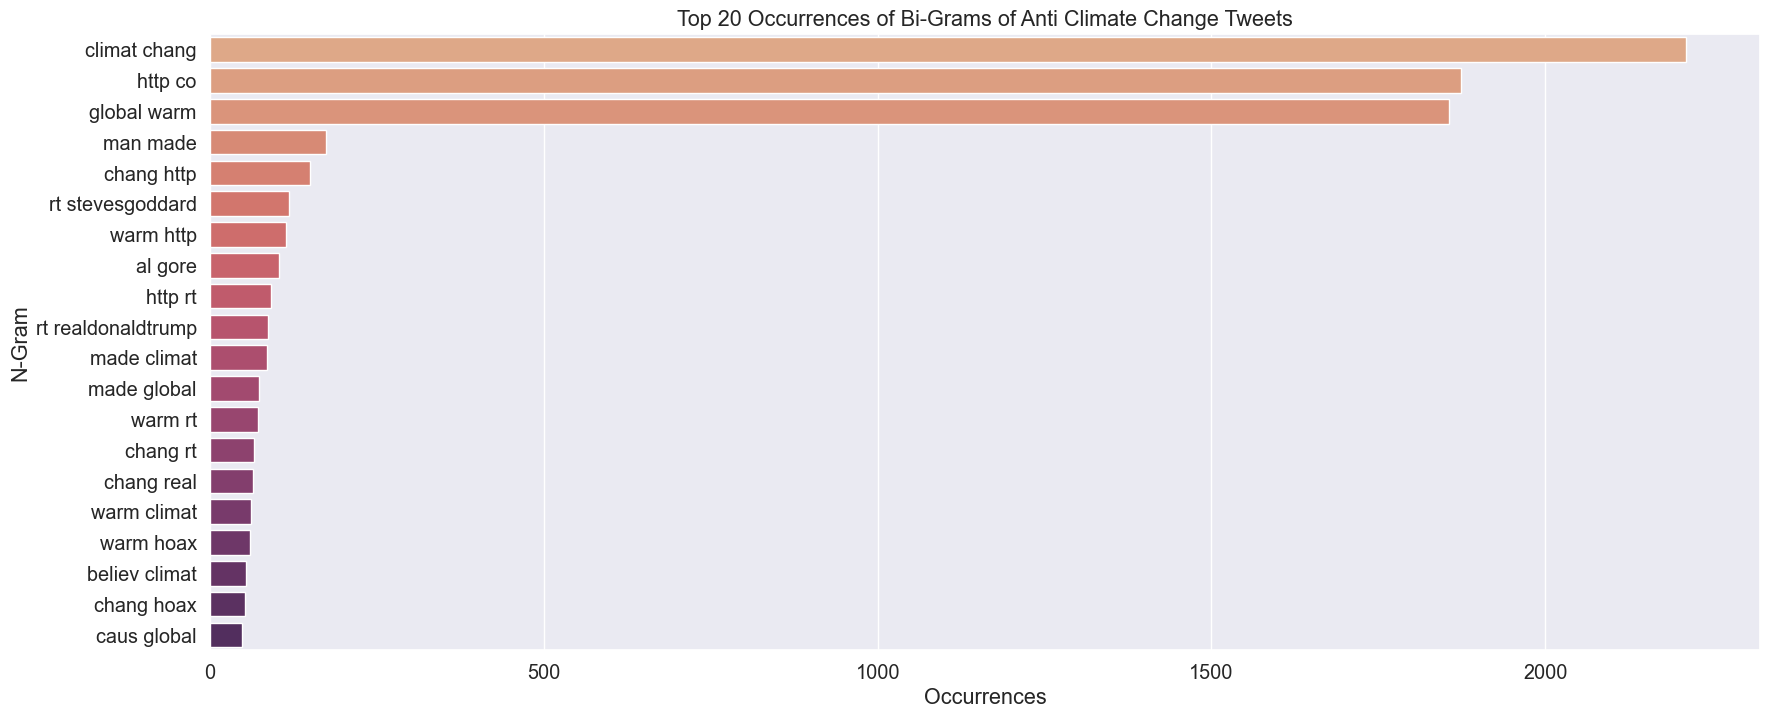

In [139]:
counterDfAntiTop = generateWordList(dfSub, -1, SIZE)
counterDfAntiTop = counterDfAntiTop.head(20)
print(counterDfAntiTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")

"climat change", "http co" and "global warm" have appeared the most time in the tweets that are refuting climate change is caused by humans. "http co" seems like a link to another website.

### Top 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets (0)


***N-Gram (Sentiment: 0)
           N-Gram  Occurrences
0    climat chang         4491
1         http co         3271
2     global warm         3109
3      chang http          447
4       warm http          289
5         warm rt          236
6        chang rt          218
7     caus global          137
8       warm real          121
9         http rt          109
10  believ climat          107
11    talk climat           99
12          ðÿ ðÿ           88
13   think global           82
14   club penguin           82
15     chang real           81
16  believ global           75
17    caus climat           70
18   penguin shut           68
19     chang hoax           63


/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_89312/2684317223.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNeutralTop, palette="ch:s=.25,rot=-.25")


<Axes: title={'center': 'Top 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

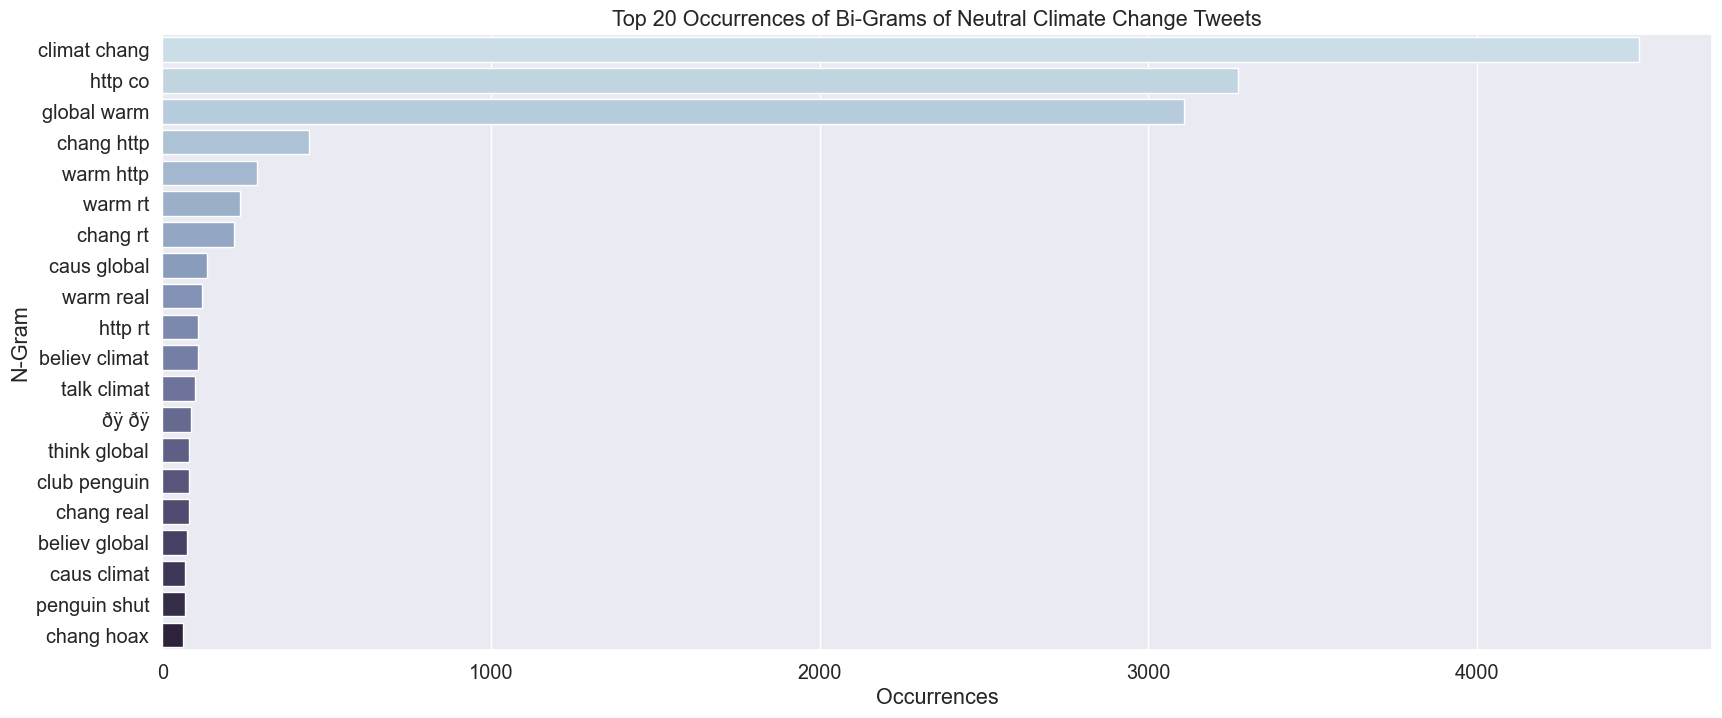

In [140]:
counterDfNeutral = generateWordList(dfSub, 0, SIZE)
counterDfNeutralTop = counterDfNeutral.head(20)
print(counterDfNeutralTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNeutralTop, palette="ch:s=.25,rot=-.25")

Neutral tweets also have very similar patterns to the anti tweets. "climat chang", "http co" and "global warm" are the top 3 followed by "chang http", "warm http", "warm rt" and "chang rt". "rt" is short for "re-tweet".
The only difference may be notable here is that "man made" was not mentioned as the top 20 occurrences in the neutral tweets.

### Top 20 Occurrences of Bi-Grams of Pro Climate Change Tweets (1)


***N-Gram (Sentiment: 1)
                   N-Gram  Occurrences
0            climat chang        19124
1                 http co        12378
2             global warm         3851
3              chang http         2799
4           believ climat         1427
5            fight climat          836
6                 http rt          788
7            chang denier          711
8              chang real          679
9                  go die          540
10               think go          514
11         husband believ          512
12            die husband          510
13     rt stephenschlegel          507
14  stephenschlegel think          507
15             co sjofonã          506
16              warm http          494
17               chang rt          477
18            deni climat          448
19             sjofonã rt          435


/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_89312/3457609949.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.1,l=0.8")


<Axes: title={'center': 'Top 20 Occurrences of Bi-Grams of Pro Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

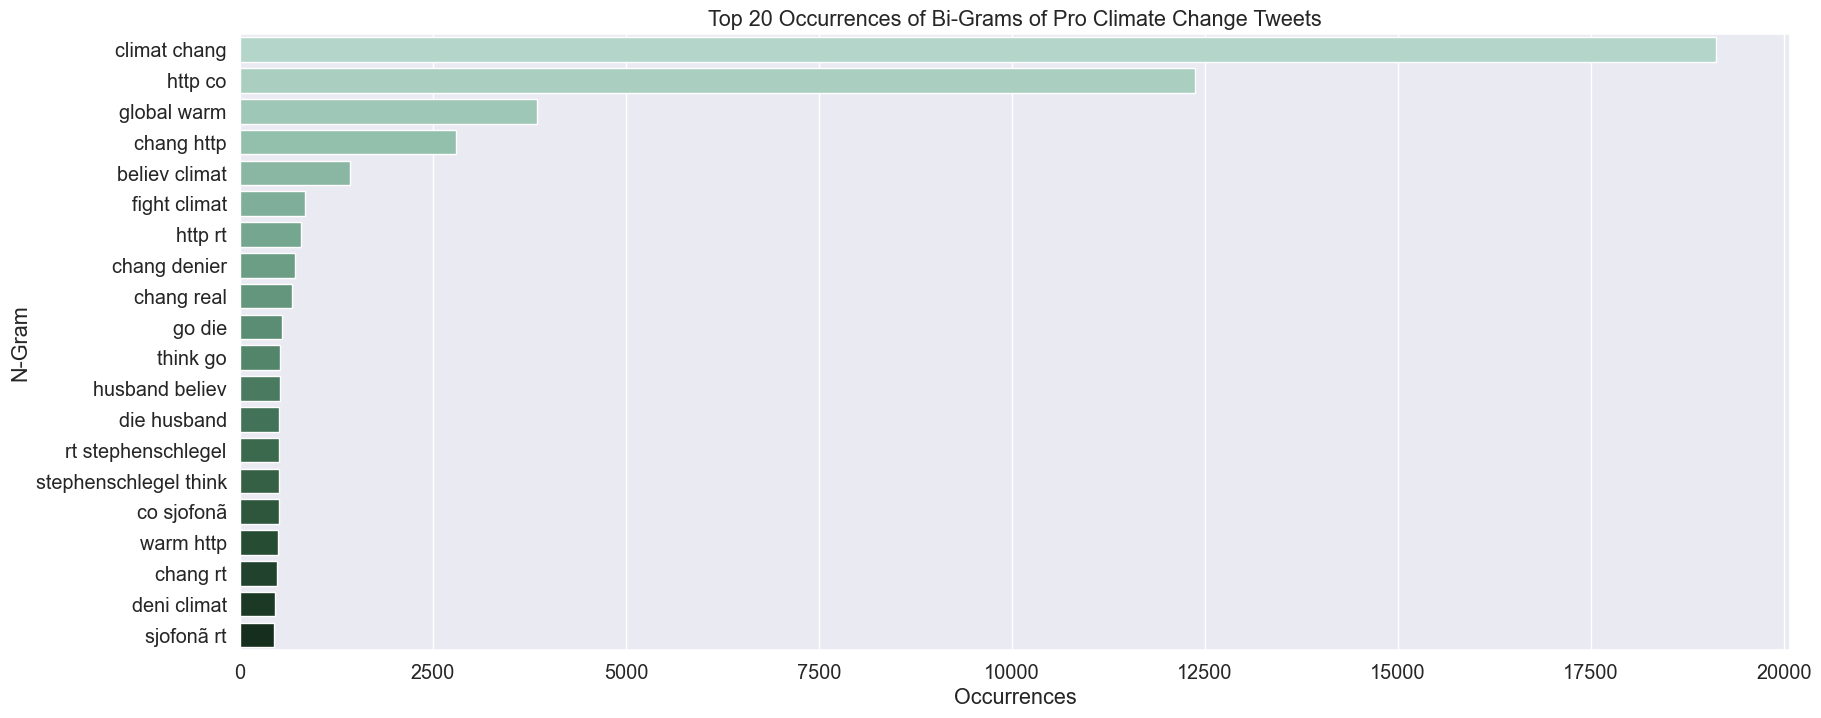

In [141]:
counterDfPro = generateWordList(dfSub, 1, SIZE)
counterDfProTop = counterDfPro.head(20)
print(counterDfProTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Bi-Grams of Pro Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.1,l=0.8")

Again, the top 3 bi-grams are "climat chang", "http co" and "global warm" for pro climate change tweets. A considerable size of tweets are containing "believ climat" and "fight climat". Perhaps people were explicitly expressing that they are "believing in climate change" or "fighting for the climate change". 

## Tri-Grams
Let's try tri-grams and see if it finds more meaningful combinations of words than bi-grams.

In [142]:
SIZE = 3

## Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets (-1)


***N-Gram (Sentiment: -1)
                 N-Gram  Occurrences
0     climat chang http          146
1         chang http co          138
2      global warm http          112
3          warm http co          105
4     made climat chang           82
5       man made climat           78
6        global warm rt           71
7      made global warm           71
8       man made global           67
9     climat chang real           65
10      climat chang rt           61
11     global warm hoax           60
12   global warm climat           59
13    climat chang hoax           52
14  believ climat chang           52
15    warm climat chang           50
16     global warm data           45
17    caus climat chang           44
18     caus global warm           44
19    global warm creat           43


/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_89312/232955823.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

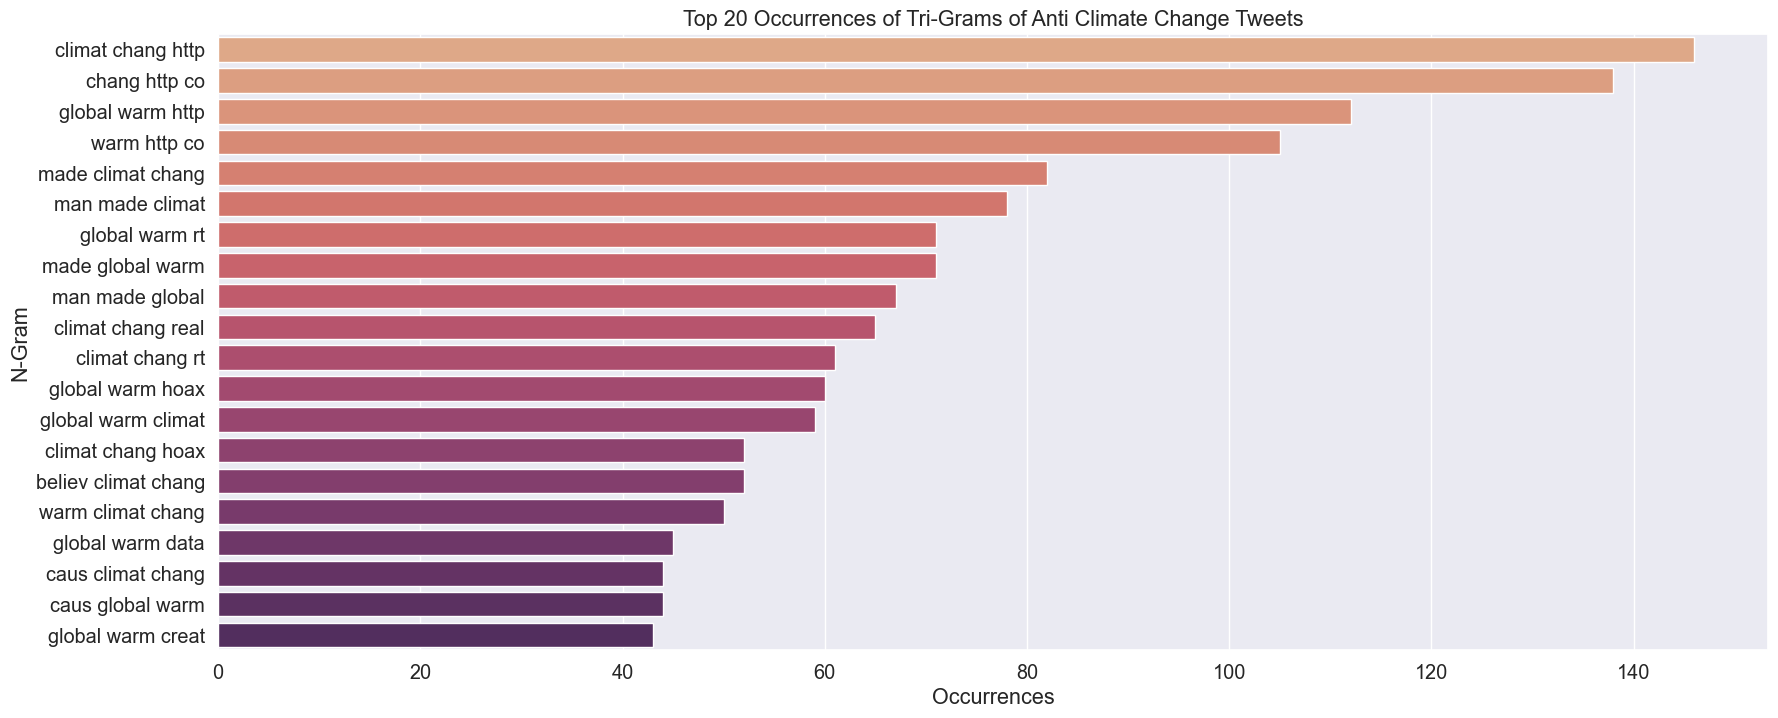

In [143]:
counterDfAntiTop = generateWordList(dfSub, -1, SIZE)
counterDfAntiTop = counterDfAntiTop.head(20)
print(counterDfAntiTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")

### Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets (0)


***N-Gram (Sentiment: 0)
                 N-Gram  Occurrences
0     climat chang http          444
1         chang http co          424
2      global warm http          289
3          warm http co          280
4        global warm rt          235
5       climat chang rt          214
6      caus global warm          137
7      global warm real          121
8   believ climat chang          106
9     talk climat chang           96
10    think global warm           81
11    climat chang real           81
12   believ global warm           74
13    caus climat chang           69
14    club penguin shut           68
15    climat chang hoax           63
16   think climat chang           58
17     stop global warm           57
18   fight climat chang           56
19     say climat chang           52


/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_89312/3158933535.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNeutralTop, palette="ch:s=.25,rot=-.25")


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

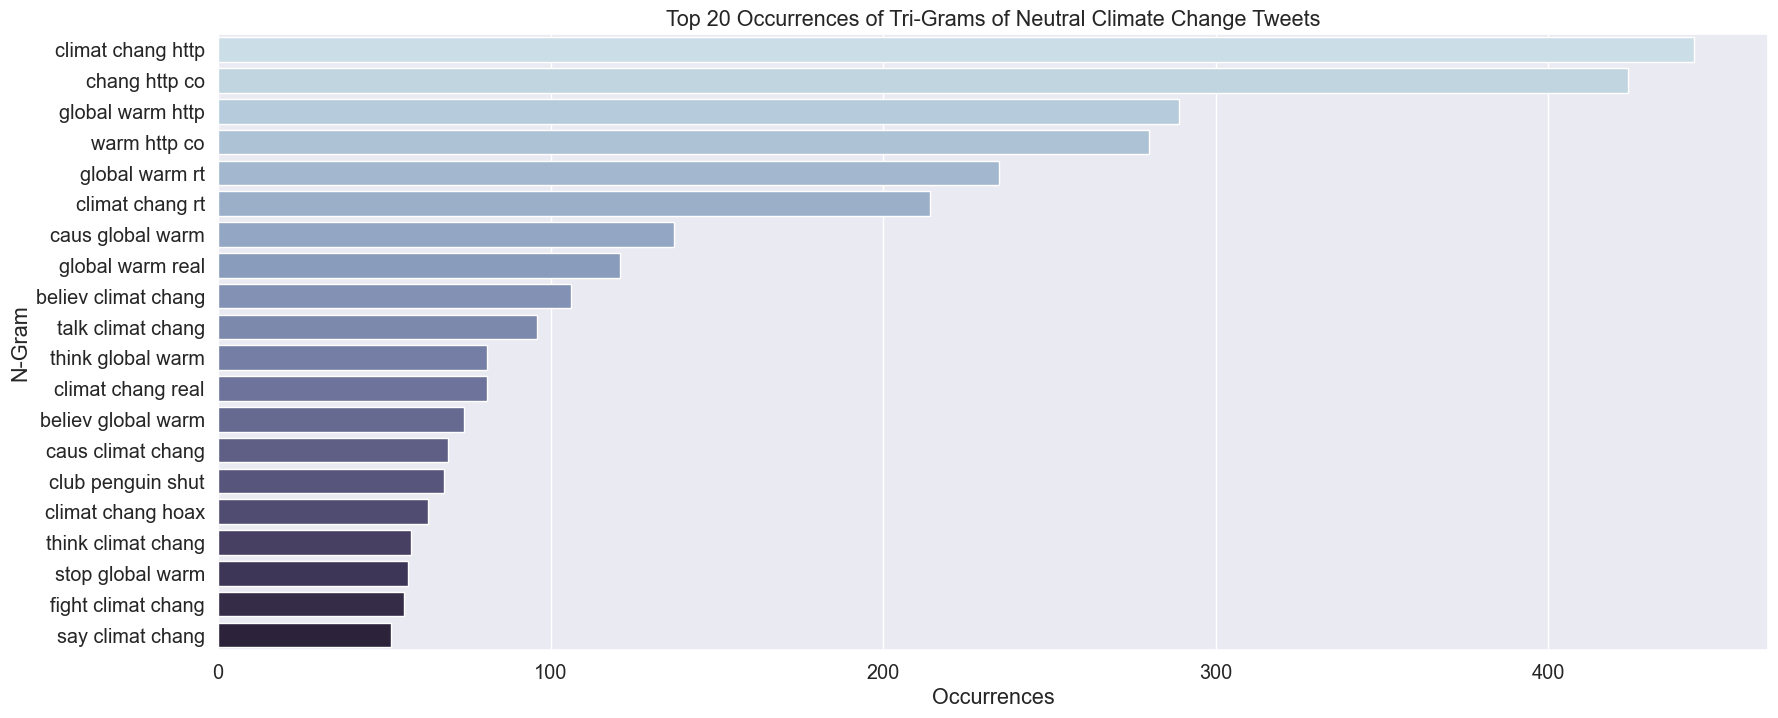

In [144]:
counterDfNeutral = generateWordList(dfSub, 0, SIZE)
counterDfNeutralTop = counterDfNeutral.head(20)
print(counterDfNeutralTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNeutralTop, palette="ch:s=.25,rot=-.25")

### Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets (1)


***N-Gram (Sentiment: 1)

/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_89312/1437867144.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.2,l=.6")



                      N-Gram  Occurrences
0          climat chang http         2787
1              chang http co         2635
2        believ climat chang         1422
3         fight climat chang          822
4        climat chang denier          711
5          climat chang real          679
6      husband believ climat          512
7               think go die          510
8             go die husband          510
9         die husband believ          510
10  rt stephenschlegel think          507
11  stephenschlegel think go          507
12           http co sjofonã          506
13          global warm http          480
14              warm http co          470
15           climat chang rt          465
16             co sjofonã rt          435
17         deni climat chang          428
18        tackl climat chang          385
19       combat climat chang          366


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

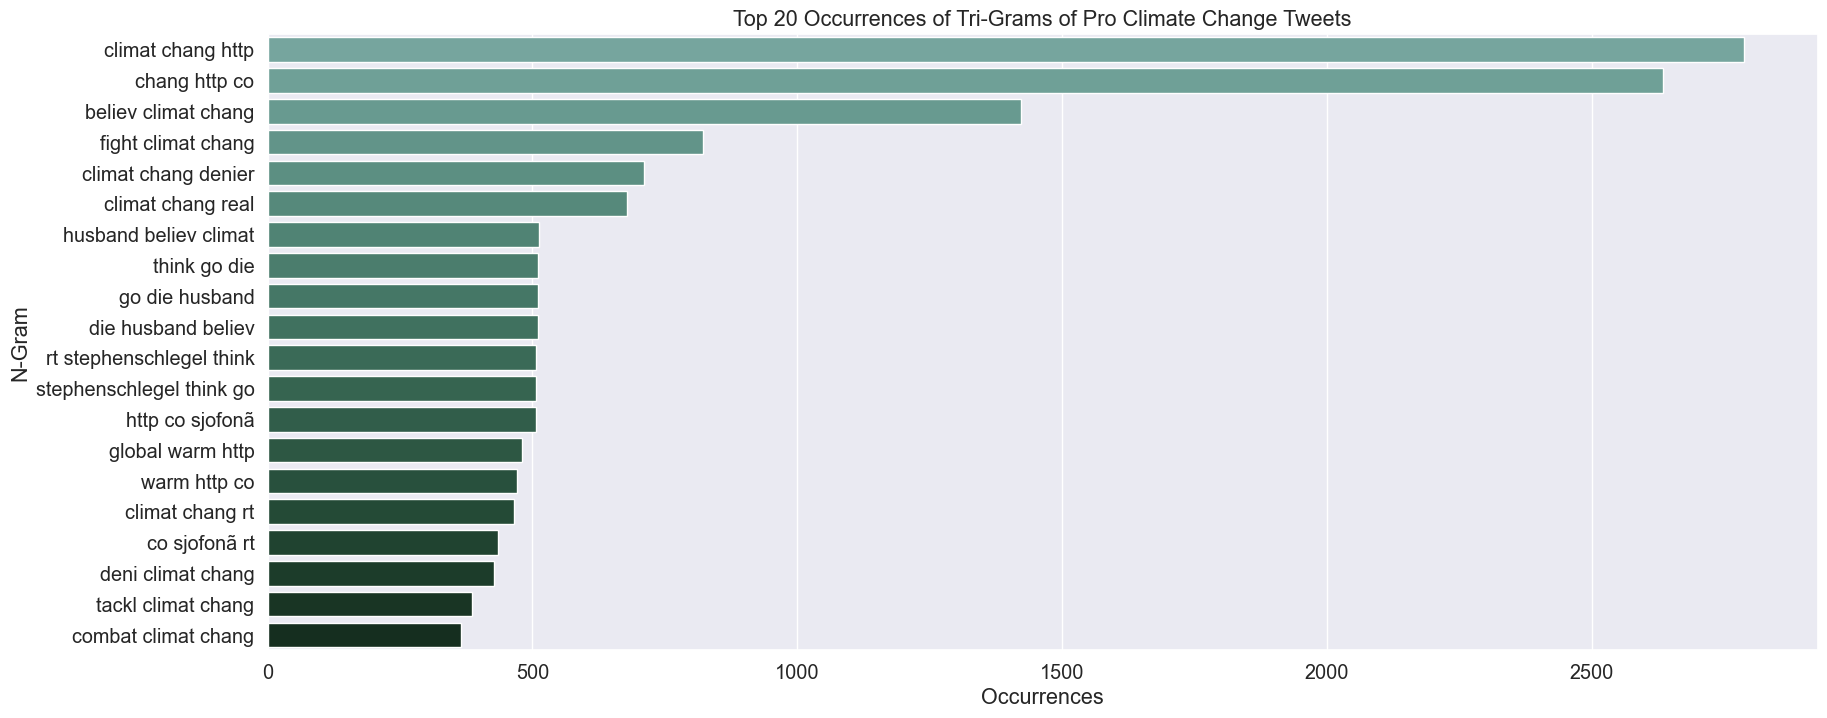

In [145]:
counterDfPro = generateWordList(dfSub, 1, SIZE)
counterDfProTop = counterDfPro.head(20)
print(counterDfProTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.2,l=.6")

Overall, it seems like tri-grams grab more accurate actions or emotions associated with climate change or global warming.

# Model Development
Various models will be built to predict the sentiment of tweets pertaining to climate change.

In [146]:
def evaluateModel(model, X_test, y_test, title):
    '''
    print out classification scores
    :param model: used model
    :param X_test:
    :param y_test:
    :param title: title of the model
    '''
    print("\n*** " + title + " ***")
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions, average='weighted')
    precision = metrics.precision_score(y_test, predictions, average='weighted')
    f1 = metrics.f1_score(y_test, predictions, average='weighted')

    clsScoreDict = {
        "accuracy": accuracy
        , "recall": recall
        , "precision": precision
        , "f1": f1
    }

    print("Accuracy:  " + str(accuracy))
    print("Precision: " + str(precision))
    print("Recall:    " + str(recall))
    print("F1:        " + str(f1))
    print("\n\n")

    return clsScoreDict

In [147]:
def modelAndPredict(X, target, model):
    '''
    Build model and predict scores.

    :param X: X contains the stemmed and vectorized sentences.
    :param target: the sentiment rating
    :param model: selected model
    :return: X_test, y_test, and y_predicted values.
    '''

    modelType = model.__class__.__name__

    # Create training set with 75% of data and test set with 25% of data.
    X_train, X_test, y_train, y_test = train_test_split(
        X, target, train_size=0.75
    )

    # Build the model with the training data.
    clfModel = model.fit(X_train, y_train)
    clsScoreDict = evaluateModel(clfModel, X_test, y_test, modelType)


    # Predict target values.
    y_prediction = model.predict(X_test)

    return X_test, y_test, y_prediction, clsScoreDict

In [148]:
def showFormattedConfusionMatrix(y_test, y_predicted):
    '''
    Draw the confusion matrix.
    :param y_test
    :param y_predicted
    :return:
    '''
    # print a simple confusion matrix
    cm = metrics.confusion_matrix(y_test.values, y_predicted)
    print(cm)

    # Show confusion matrix with colored background.
    Index = ['Actual -1', 'Actual 0', 'Actual 1', 'Actual 2', ]
    Cols = ['Pred -1', 'Pred 0', 'Pred 1', 'Pred 2']
    df = pd.DataFrame(cm, index=Index, columns=Cols)
    plt.figure(figsize=(4, 4))

    ax = sns.heatmap(df, cmap='Blues', annot=True, fmt='g')
    bottom, top = ax.get_ylim()
    ax.set(title="Movie Review Sentiment")
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30,
                       horizontalalignment='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0,
                       horizontalalignment='right')

In [149]:
# bi-gram vectorization
NGRAM_RANGE_START = 2
NGRAM_RANGE_END = 2

vectorizedTweets2, vectorDictionary2 = vectorizeList(stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END)

In [150]:
# tri-gram vectorization
NGRAM_RANGE_START = 3
NGRAM_RANGE_END = 3

vectorizedTweets3, vectorDictionary3 = vectorizeList(stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END)

In [151]:
# bi-gram & tri-gram vectorization
NGRAM_RANGE_START = 2
NGRAM_RANGE_END = 3

vectorizedTweets23, vectorDictionary23 = vectorizeList(stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END)

## 1. Logistic Regression

In [152]:
model = LogisticRegression()


*** LogisticRegression ***
Accuracy:  0.7343892226470052
Precision: 0.7276774154287926
Recall:    0.7343892226470052
F1:        0.7293736336135062



[[ 498  156  234   46]
 [ 133  939  671  132]
 [  99  432 4945  429]
 [  26   77  483 1686]]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


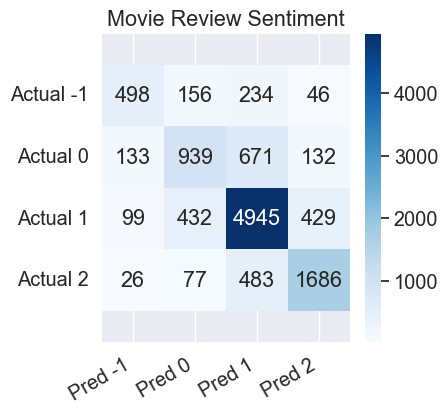

In [153]:
X_test, y_test, y_predicted, lrScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

### Bi-Gram Logistic Regression


*** LogisticRegression ***
Accuracy:  0.7074458401602038
Precision: 0.7050711803154056
Recall:    0.7074458401602038
F1:        0.6903476929870646



[[ 320  209  421   50]
 [  45  792  991  102]
 [  32  334 5055  320]
 [  16   62  632 1605]]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


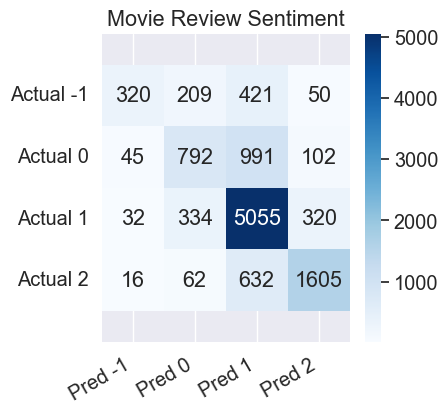

In [154]:
X_test, y_test, y_predicted, lrScoreDict2 = modelAndPredict(vectorizedTweets2, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

### Tri-gram Logistic Regression


*** LogisticRegression ***
Accuracy:  0.6638448935008192
Precision: 0.6718203645611176
Recall:    0.6638448935008192
F1:        0.6295600202570799



[[ 224  115  606   44]
 [  20  501 1327   85]
 [  24  226 5207  266]
 [   9   72  899 1361]]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


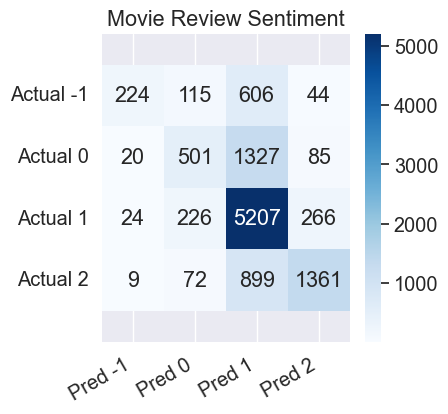

In [155]:
X_test, y_test, y_predicted, lrScoreDict3 = modelAndPredict(vectorizedTweets3, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

### Bi-Gram & Tri-Gram Logistic Regression
Note that I was not able to vectorize data ranging from 1 to 3-gram due to memory issue on my device.


*** LogisticRegression ***
Accuracy:  0.7027125432368468
Precision: 0.7039828096112541
Recall:    0.7027125432368468
F1:        0.6874880423634698



[[ 318  204  408   40]
 [  19  824  965  103]
 [  40  379 5068  329]
 [  11   69  699 1510]]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


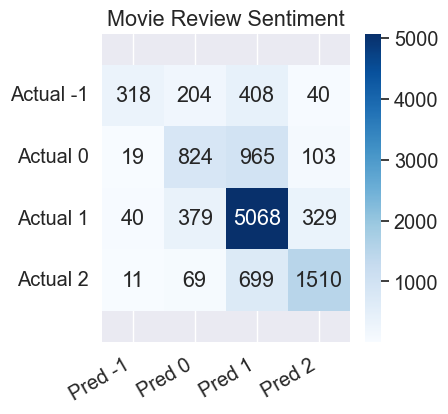

In [156]:
X_test, y_test, y_predicted, lrScoreDict23 = modelAndPredict(vectorizedTweets23, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

### N-gram Comparisons
We have built different vectorized sentences using different ranges of N-grams (1, 2, 3, and 2 to 3). Each of them was fed to a logistic regression model and evaluated based on classification scores such as accuracy, precision, recall and F1. In this section, we will compare all the scores and see what N-gram has worked the best.

In [157]:
lsScoreDf = pd.DataFrame(lrScoreDict, index=["-"])
lsScoreDf2 = pd.DataFrame(lrScoreDict2, index=["Bi-gram"])
lsScoreDf3 = pd.DataFrame(lrScoreDict3, index=["Tri-gram"])
lsScoreDf23 = pd.DataFrame(lrScoreDict23, index=["Bi-gram and Tri-gram"])

lsScoreComparisonDf = pd.concat([lsScoreDf, lsScoreDf2, lsScoreDf3, lsScoreDf23])
lsScoreComparisonDf

,accuracy,recall,precision,f1
-,0.734389,0.734389,0.727677,0.729374
Bi-gram,0.707446,0.707446,0.705071,0.690348
Tri-gram,0.663845,0.663845,0.671820,0.629560
Bi-gram and Tri-gram,0.702713,0.702713,0.703983,0.687488


Logistic regression has worked the best when no N-gram was used to vectorize the sentences. Let's see if we can improve the model even further using different classification models.

## 2. Decision Tree

In [158]:
model = DecisionTreeClassifier(max_depth=20)


*** DecisionTreeClassifier ***
Accuracy:  0.6032222829055162
Precision: 0.6108356658065678
Recall:    0.6032222829055162
F1:        0.5537578895706087



[[ 209   87  645   62]
 [  38  330 1491   76]
 [  62  142 5128  345]
 [  13   13 1385  960]]


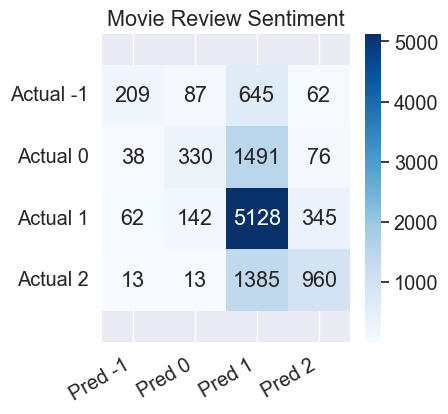

In [159]:
X_test, y_test, y_predicted, treeScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

## 3. Random Forest Classifier

In [160]:
model = RandomForestClassifier()


*** RandomForestClassifier ***
Accuracy:  0.7083560895685418
Precision: 0.7129434443478015
Recall:    0.7083560895685418
F1:        0.6903221080566432



[[ 295  197  437   60]
 [  27  811  948  103]
 [  18  347 5175  276]
 [   7   43  741 1501]]


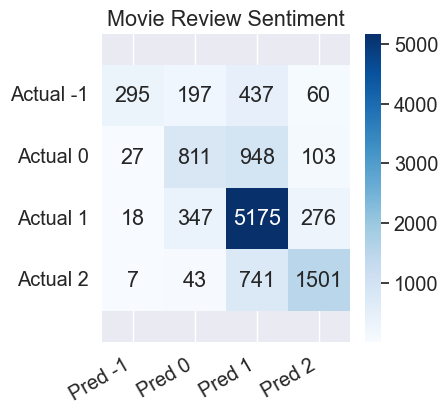

In [161]:
X_test, y_test, y_predicted, rfScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

## 4. Extra Trees Classifier

In [162]:
model = ExtraTreesClassifier()


*** ExtraTreesClassifier ***
Accuracy:  0.7042599672310212
Precision: 0.7061122661646868
Recall:    0.7042599672310212
F1:        0.6866892333040772



[[ 308  170  439   62]
 [  44  859 1005  106]
 [  36  328 5022  291]
 [   8   29  731 1548]]


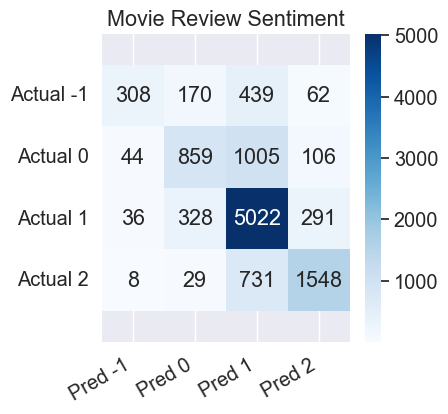

In [163]:
X_test, y_test, y_predicted, xtreeScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

## 5. K Neighbors Classifier

In [164]:
model = KNeighborsClassifier()


*** KNeighborsClassifier ***
Accuracy:  0.4251774986346259
Precision: 0.6038470584640535
Recall:    0.4251774986346259
F1:        0.43845810115802014



[[ 132  744  142   12]
 [  51 1503  277   23]
 [ 105 3168 2322  121]
 [  38  898  736  714]]


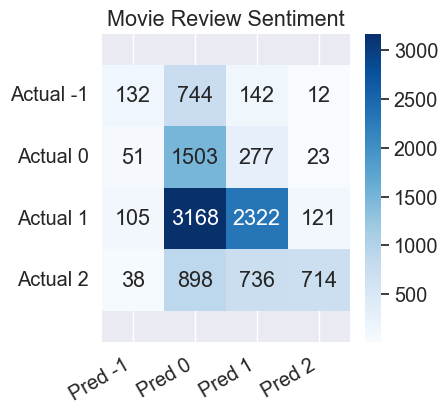

In [165]:
X_test, y_test, y_predicted, knnScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

## 6. Linear Support Vector Classifier (SVC)

In [166]:
model = SVC()


*** SVC ***
Accuracy:  0.7328417986528308
Precision: 0.7335997191260072
Recall:    0.7328417986528308
F1:        0.7169516323921453



[[ 389  150  379   48]
 [  36  806  974  117]
 [  32  237 5245  319]
 [   9   35  599 1611]]


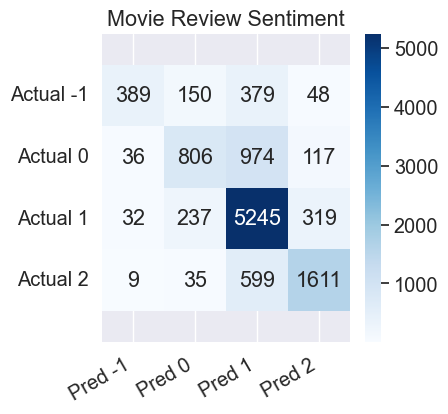

In [167]:
X_test, y_test, y_predicted, svcScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

## 7. Ridge Classifier

In [168]:
model = RidgeClassifier()


*** RidgeClassifier ***
Accuracy:  0.722920080101948
Precision: 0.7183651295270761
Recall:    0.722920080101948
F1:        0.7170287190694902



[[ 542  170  247   53]
 [  74  978  743  164]
 [  79  422 4780  425]
 [  21   78  568 1642]]


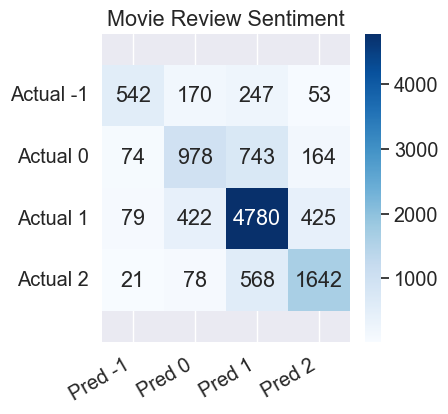

In [169]:
X_test, y_test, y_predicted, ridgeScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

# Model Comparisons

In [170]:
lrScoreDf = pd.DataFrame(lrScoreDict, index=["Logistic Regression"])
treeScoreDf = pd.DataFrame(treeScoreDict, index=["Decision Tree"])
rfScoreDf = pd.DataFrame(rfScoreDict, index=["Random Forest Classification"])
xtreeScoreDf = pd.DataFrame(xtreeScoreDict, index=["Extra Trees Classification"])
knnScoreDf = pd.DataFrame(knnScoreDict, index=["K Neighbors Classification"])
svcScoreDf = pd.DataFrame(svcScoreDict, index=["Linear Support Vector Classifier Classification"])
ridgeScoreDf = pd.DataFrame(ridgeScoreDict, index=["Ridge Classification"])

clsCompDf = pd.concat([lrScoreDf, treeScoreDf, rfScoreDf, xtreeScoreDf, knnScoreDf, svcScoreDf, ridgeScoreDf])

clsCompDf.sort_values(by=["accuracy", "f1"], ascending = False)

,accuracy,recall,precision,f1
Logistic Regression,0.734389,0.734389,0.727677,0.729374
Linear Support Vector Classifier Classification,0.732842,0.732842,0.733600,0.716952
Ridge Classification,0.722920,0.722920,0.718365,0.717029
Random Forest Classification,0.708356,0.708356,0.712943,0.690322
Extra Trees Classification,0.704260,0.704260,0.706112,0.686689
Decision Tree,0.603222,0.603222,0.610836,0.553758
K Neighbors Classification,0.425177,0.425177,0.603847,0.438458


**Logistic Regression** seems to be performing the best because it has the highest accuracy, recall, precision and f1 among all models. **SVC** and **Ridge Classification** are also good runner-ups.

# Binary File Export
To reuse the built model to predict other tweets, we will be saving the model as a binary file.

In [171]:
def modelAndPredict(X, target, model):
    '''
    Build model and predict scores.

    :param X: X contains the stemmed and vectorized sentences.
    :param target: the sentiment rating
    :param model: selected model
    :return: X_test, y_test, and y_predicted values.
    '''

    modelType = model.__class__.__name__

    # Create training set with 75% of data and test set with 25% of data.
    X_train, X_test, y_train, y_test = train_test_split(
        X, target, train_size=0.75
    )

    # Build the model with the training data.
    clfModel = model.fit(X_train, y_train)

    # save model to a pickle file
    # create directory for models
    if (not path.exists("./model")):
        makedirs('./model')
    pickle.dump(clfModel, open(f"./model/climate_change_tweet_sentiment_{modelType}.dat", "wb"))

    # load model
    loadedModel = pickle.load(open(f"./model/climate_change_tweet_sentiment_{modelType}.dat", "rb"))

    clsScoreDict = evaluateModel(loadedModel, X_test, y_test, modelType)


    # Predict target values.
    y_prediction = model.predict(X_test)

    return X_test, y_test, y_prediction, clsScoreDict

In [172]:
model = LogisticRegression()


*** LogisticRegression ***
Accuracy:  0.7318405243036592
Precision: 0.7263393483037879
Recall:    0.7318405243036592
F1:        0.7253179824630095



[[ 533  181  253   59]
 [  85  966  749  148]
 [  81  393 4810  407]
 [  19   77  494 1731]]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


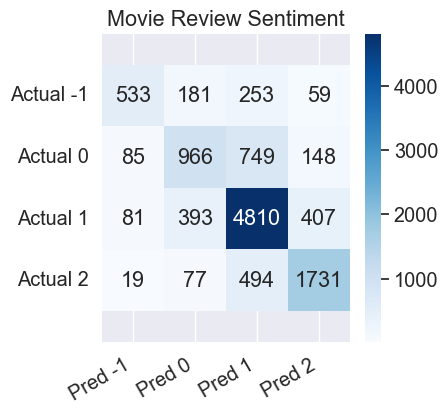

In [173]:
X_test, y_test, y_predicted, lrScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

We also need a reference to vectors for each word found in the dataset. The word dictionary will be exported as a JSON file. Each unique word in the dataset is associated with its vector value.

In [174]:
# with open("wordDictionary.json", "w") as fp:
#     json.dump(vectorDictionary, fp)